Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## This notebook takes a cleaned file created by notebook "Lending Club Cleaning Notebook v2.0" and performs graphing and statistical analysis.   

23JUN 15 - logistic regaression with feature selection implemented.    Graphing ROC function.  Graphing interest rates per lending club classification.   Almost done with logic to calculate total returns. 

30 July - Separated graphing notebook from statistical analysis notebook.  Both read same file, produced by cleaning notebook. 

 

In [1]:
# load relevant libraries
# This Workbook assumes the presence of a cleaned Lending Club file.   For more details on cleaning
# And calculated features, see xxx

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns


%matplotlib inline
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_07-12_CLEANED.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_12-13_CLEANED.csv"
# url = "/Users/Glenn/Documents/LendingClub/LendingClub_13-14_CLEANED.csv"
url = "/Users/Glenn/Documents/LendingClub/LendingClub_CLEANED_V2.csv"
lcd = pd.read_csv(url, 
                       parse_dates=['last_pymnt_date','issue_date',
                                   'last_credit_pull_date','next_pymnt_date'])


### The code below is where the regressions are run.  Currently, I am using a simple logistic regression against one feature.   Next steps will be to use more features and explcitly feature selection.  Hopefully, I'll be able to also do better model selection and tuning.  

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
import sklearn
import sklearn.linear_model as lm
import sklearn.grid_search as gs

# Define features, 

total_features_selected = ['HO - Rent','HO - Own','HO - Mortgage','HO - Other','loan_amnt','clean_rate','annual_inc','delinq_2yrs','fico_interp',
                'Total_Defaults','mths_since_last_delinq','PURP:credit_card','PURP:car','PURP:small_business','PURP:other',
                'PURP:wedding','PURP:debt_consolidation','PURP:home_improvement', 'PURP:major_purchase','PURP:medical',
                'PURP:moving','PURP:vacation','PURP:house','PURP:renewable_energy','dti','emp_length_numeric',
                'A1','A2','A3','A4','A5',
                'B1','B2','B3','B4','B5',
                'C1','C2','C3','C4','C5',
                'D1','D2','D3','D4','D5',
                'E1','E2','E3','E4','E5',
                'F1','F2','F3','F4','F5',
                'G1','G2','G3','G4','G5']

# Select features for first regression
'''
features_selected=['HO - Rent','HO - Own','HO - Mortgage','HO - Other','loan_amnt','clean_rate','annual_inc','delinq_2yrs','fico_interp',
                'Total_Defaults','mths_since_last_delinq','PURP:credit_card','PURP:car','PURP:small_business','PURP:other',
                'PURP:wedding','PURP:debt_consolidation','PURP:home_improvement', 'PURP:major_purchase','PURP:medical',
                'PURP:moving','PURP:vacation','PURP:house','PURP:renewable_energy','emp_length_numeric']
'''
features_selected=['HO - Rent','HO - Own','HO - Mortgage','HO - Other','loan_amnt','clean_rate','annual_inc','delinq_2yrs','fico_interp',
                'mths_since_last_delinq','PURP:credit_card','PURP:car','PURP:small_business','PURP:other',
                'PURP:wedding','PURP:debt_consolidation','PURP:home_improvement', 'PURP:major_purchase','PURP:medical',
                'PURP:moving','PURP:vacation','PURP:house','PURP:renewable_energy','emp_length_numeric']

# Create df of features, then drop nas. 
lcd_temp2= lcd[total_features_selected].dropna()

# select features which are NOT LC ratings.  
X = lcd_temp2[total_features_selected].drop(['Total_Defaults'],axis=1) # This is the first set of features we use for feature reduction
y = lcd_temp2['Total_Defaults']               # This is the response variable - Total Defaults

#  Create train and test datasets to evaluate each model
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,train_size = 0.10)

In [3]:
# Form of Recursive Feature Selection with Cross Validation
# class sklearn.feature_selection.RFECV(estimator, step=1, cv=None, scoring=None, 
#                                       estimator_params=None, verbose=0)[source]

# Use RFECV to reduce features

#  Create a logistic regression estimator 
logreg = lm.LogisticRegression()

# Use RFECV to pick best features, using Stratified Kfold
rfecv =   RFECV(estimator=logreg, cv=StratifiedKFold(ytrain, 10), scoring='roc_auc')

# Fit the features to the response variable
X_new = rfecv.fit_transform(Xtrain[features_selected], ytrain)

In [4]:
# Select the features which are most important

selected_feature_names = []
for i in range(0, len(rfecv.support_)): 
    if rfecv.support_[i] == True :
        selected_feature_names.append(X.columns[i])
        
print"%d features selected:"  % rfecv.n_features_
print selected_feature_names
# X_newdf = pd.DataFrame(X_new,columns = column_names)

7 features selected:
['loan_amnt', 'annual_inc', 'delinq_2yrs', 'fico_interp', 'mths_since_last_delinq', 'PURP:credit_card', 'dti']


In [4]:
# Form of Recursive Feature Selection with Cross Validation
# class sklearn.feature_selection.RFECV(estimator, step=1, cv=None, scoring=None, 
#                                       estimator_params=None, verbose=0)[source]

# Use RFECV to reduce features

#  Create a logistic regression estimator 
# logreg = lm.LogisticRegression()

# Use RFECV to pick best features, using Stratified Kfold.  USE LEAVE ONE OUT CV FOR THIS RUN
# rfecv_loo =   RFECV(estimator=logreg, cv=StratifiedKFold(ytrain, 10), scoring='roc_auc')

# Fit the features to the response variable
#  X_new = rfecv.fit_transform(Xtrain[features_selected], ytrain)

In [5]:
# Let's try to tune some logreg hyperparameters for the feature set X.   
# pipeline with scaling to select best C and penalty
# Use Cross Validation to create train, test samples from data

# Make pipeline normalization -> logistic regression for Grid SearchCV
pipe = make_pipeline(preprocessing.StandardScaler(), lm.LogisticRegression())

# from sklearn.svm import l1_min_c
# cs = l1_min_c(X, y, loss='log') 

C_range = 10.**np.arange(-5, 1)

penalty_options = ['l1', 'l2']

skf = StratifiedKFold(ytrain, 5)

param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options,
                 logisticregression__class_weight=[None, 'auto'])

grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc',refit=True)

# grid = GridSearchCV(logreg, param_grid, cv=skf, scoring='roc_auc')
grid.fit(X_new, ytrain)
# grid.fit(Xtrain,ytrain)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 0.  0. ...,  0.  0.], n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'logisticregression__class_weight': [None, 'auto'], 'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [6]:
# Use grid tuned classifier to predict probabilities on test dataset, put in y_probas
y_probas = grid.predict_proba(Xtest[selected_feature_names])[:,1]

In [17]:
# This routine from STackOverflow.  Illustrates how to index arrays within nested cross validation folds. 
# Put all things together with the nested cross-validation
# generate a pandas dataframe to store prediction probability

# from sklearn.metrics import classification_report
# from sklearn.datasets import make_classification

# create dataframes from a subset of Xtrain, ytrain data (for speed)
# X_ = Xtrain[features_selected]
# y_ = ytrain

# kfold_df holds predicted probabilities from Grid esitmator. 
# kfold_df = pd.DataFrame(0.0, index=np.arange(len(y_)), columns=pd.unique(y_.values.ravel()))

# report = []  # to store classification report

# split = StratifiedKFold(y_, n_folds=5, shuffle=True, random_state=123)
# for train_index, test_index in split:

    #   grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(y_[train_index], n_folds=5), scoring='roc_auc')
    
    # Won't this find different hyperparametrs per fold??
    # grid.fit(X_.iloc[train_index], y_.iloc[train_index])

    # y_pred_probs = grid.predict_proba(X_.iloc[test_index])
    # kfold_df.loc[test_index, :] = y_pred_probs

    # y_pred = grid.predict(X_.iloc[test_index])
    # report.append(classification_report(y_.iloc[test_index], y_pred))

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

In [9]:
# Now lets use KNN 

# class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', 
#                algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, **kwargs)

from sklearn.neighbors import KNeighborsClassifier


# Iterate from 1 - 51 neighbors, by 2
# n_neighbors = range(1, 11, 2)
# n_neighbors = 5

############################################################################
# Use grid search to find best KNN model...
# Need to scale all continuous features, pipe will allow us to use GridSearchCV
# pipe = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier())

# param_grid = dict(kneighborsclassifier__n_neighbors = n_neighbors)

# Use statified KFold because y is inbalanced. 
# skf = StratifiedKFold(ytrain, 3)

# Grid search for best n_neighbors
# clf = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc',refit=True)

#####################################################################
#  Separate Loop through each neighbors value from 1 to 51 and append
#  the scores
# Not pipe, but scaled to N(0,1)

Xtrain_Scaled = preprocessing.StandardScaler().fit_transform(Xtrain)
Xtest_Scaled = preprocessing.StandardScaler().fit_transform(Xtest)

# scores will hold series of ROC_AUC scores
# scores = []

# Loop through n_neighbors and append ROC_AUC test results.
# for n in n_neighbors:
#     clf = KNeighborsClassifier(n)
#    clf.fit(Xtrain_Scaled, ytrain)
#    y_probas_KNN = clf.predict_proba(Xtest_Scaled)[:,1]
#    scores.append(roc_auc_score(ytest,y_probas_KNN))
    
###################
# Simple instantiation of KNN Classifier
clf = KNeighborsClassifier(n_neighbors = 5,weights='distance')
#  Fit Model 
clf.fit(Xtrain_Scaled, ytrain)
# Predict probabilities
# y_probas_KNN = clf.predict_proba(Xtest_Scaled)[:,1]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='distance')

In [12]:
y_probas_KNN = clf.predict_proba(Xtest_Scaled[:100000,])[:,1]

In [11]:
Xtest_Scaled.shape

(400725, 60)

In [15]:
roc_auc_score(ytest[:100000,],y_probas_KNN)

0.54458791204946977

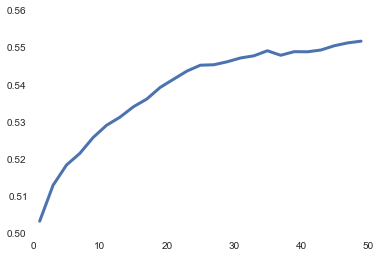

In [35]:
plt.plot(n_neighbors, scores, linewidth=3.0)

In [18]:
# Try a Decision Tree Classifier

from sklearn import tree

clf = tree.DecisionTreeClassifier(class_weight='auto',max_depth=9)
clf = clf.fit(Xtrain, ytrain)
y_probas_tree = clf.predict_proba(Xtest)[:,1]

print "AUC Score: %f" % roc_auc_score(ytest,y_probas_tree)

AUC Score: 0.644604


In [21]:
Model_Outputs = pd.DataFrame({ 'Dec Tree':clf.feature_importances_},index = Xtrain.columns)

In [23]:
# Try Ada Boost Classifier

from sklearn.ensemble import AdaBoostClassifier

estimators=200

bdt = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1,class_weight= 'auto'),
                         algorithm="SAMME.R",
                         n_estimators=estimators)

bdt = bdt.fit(Xtrain,ytrain)

y_probas_bdt = bdt.predict_proba(Xtest)[:,1]

print "AUC Score: %f" % roc_auc_score(ytest,y_probas_bdt)


AUC Score: 0.696376


In [24]:
# compute the feature importances

Model_Outputs['Ada Boost'] = bdt.feature_importances_

In [25]:
Model_Outputs.head()

,Dec Tree,Ada Boost
HO - Rent,0.005612,0.005
HO - Own,0.002442,0.000
HO - Mortgage,0.007301,0.000
HO - Other,0.000000,0.000
loan_amnt,0.078986,0.035


In [34]:
from sklearn.metrics import zero_one_loss
n_estimators=200

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(bdt.staged_predict(Xtest)):
    ada_discrete_err[i] = roc_auc_score(y_pred, ytest)

In [35]:
ada_discrete_err[190:199]

array([ 0.53353343,  0.53352269,  0.53336619,  0.53361174,  0.53342694,
        0.53365044,  0.53356813,  0.53390999,  0.53363629])

In [36]:
from sklearn.metrics import zero_one_loss


ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(bdt.staged_predict(Xtrain)):
    ada_discrete_err_train[i] = roc_auc_score(y_pred, ytrain)

In [37]:
ada_discrete_err_train[190:199]

array([ 0.53891496,  0.53885069,  0.53880754,  0.53895661,  0.5389464 ,
        0.53899505,  0.53916013,  0.53944818,  0.53901568])

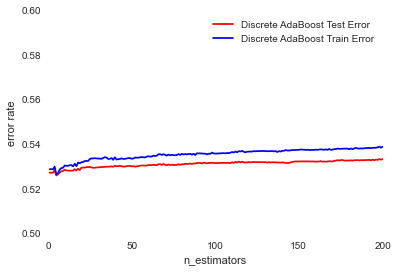

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
# ax.plot(np.arange(n_estimators) + 1, ada_real_err,
#        label='Real AdaBoost Test Error',
#        color='orange')
# ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
#        label='Real AdaBoost Train Error',
#        color='green')

ax.set_ylim((0.5, 0.6))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

In [73]:
# Try Ada Boost Classifier use Grid Search to find best 

from sklearn.ensemble import AdaBoostClassifier

bdt = AdaBoostClassifier()

# n_estimators_range = range(200,500,10)

# param_grid = {'n_estimators': n_estimators_range}

skf = StratifiedKFold(ytrain, 3)

# Grid search for best n_neighbors
grid = GridSearchCV(bdt, param_grid, cv=skf)

grid = grid.fit(Xtrain[features_selected],ytrain)

In [74]:
y_probas_bdt = grid.predict_proba(Xtest[features_selected])[:,1]

print "AUC Score: %f" % roc_auc_score(ytest,y_probas_bdt)

AUC Score: 0.692564


In [10]:
# Try Random Forest Classifier 
# class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, 
# oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 20)

# use a full grid over all parameters
'''
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
              
'''
param_grid = {"max_depth": [3, None],
              "min_samples_split": [1, 10],
              "min_samples_leaf": [1, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)

grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': [1, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': [3, None], 'min_samples_leaf': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [11]:
y_probas_rf = grid_search.predict_proba(Xtest)[:,1]

print "Random Forest Grid AUC Score: %f" % roc_auc_score(ytest,y_probas_rf)

Random Forest Grid AUC Score: 0.673751


In [13]:
print grid_search.best_params_
print grid_search.best_score_

{'min_samples_split': 1, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
0.942856597726


In [9]:
# Let's try to tune some logreg hyperparameters for feature set X_fico   
# pipeline with scaling to select best C and penalty
# Use Cross Validation to create train, test samples from data

#skf = StratifiedKFold(ytrain, 10)

# X_fico =Xtrain[['fico_interp']]
# grid_fico = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc')
# grid = GridSearchCV(logreg, param_grid, cv=skf, scoring='roc_auc')

# Fit classifier to xtrain, ytrain data.  Note X_Fico selects subfeatures from Xtrain
# grid_fico.fit(X_fico, ytrain)

In [22]:
# Use grid tuned classifier to predict probabilities, put in y_probas
# y_probas_fico = grid_fico.predict_proba(Xtest[['fico_interp']])[:,1]

In [40]:
# Let's try to tune some logreg hyperparameters for feature set X_LCRating  
# pipeline with scaling to select best C and penalty
# Use Cross Validation to create train, test samples from data
sub_grade_columns = ['A1','A2','A3','A4','A5',
                'B1','B2','B3','B4','B5',
                'C1','C2','C3','C4','C5',
                'D1','D2','D3','D4','D5',
                'E1','E2','E3','E4','E5',
                'F1','F2','F3','F4','F5',
                'G1','G2','G3','G4','G5']


X_LCR = Xtrain[sub_grade_columns]

skf = StratifiedKFold(ytrain, 10)
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)
# param_grid = dict(lm__C=C_range, lm__penalty=penalty_options)

grid_LCR = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc')

grid_LCR.fit(X_LCR, ytrain)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 0.  0. ...,  0.  0.], n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [41]:
# Use grid tuned classifier to predict probabilities, put in y_probas
y_probas_LCR = grid_LCR.predict_proba(Xtest[sub_grade_columns])[:,1]

In [42]:
from scipy import interp

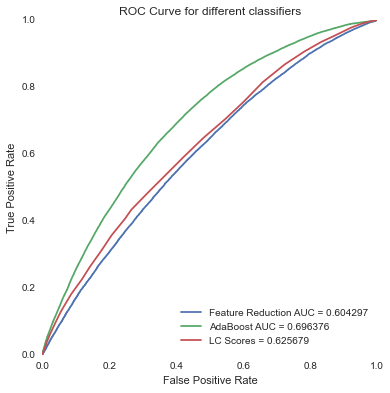

In [44]:
# Generate ROC Curves from y and y_probas calculated on individual feature sets

fpr, tpr, thresholds= roc_curve(ytest, y_probas)
fpr1, tpr1, thresholds1 = roc_curve(ytest, y_probas_bdt)
fpr2, tpr2, thresholds2 = roc_curve(ytest, y_probas_LCR)

plt.figure(figsize=(6,6))

# create legend complete with ROC_AUC score for each feature set. 
Features, = plt.plot(fpr, tpr,label = 'Feature Reduction AUC = %f' % roc_auc_score(ytest,y_probas))
Fico, = plt.plot(fpr1, tpr1,label = 'AdaBoost AUC = %f' % roc_auc_score(ytest,y_probas_bdt))
LC, = plt.plot(fpr2, tpr2,label = 'LC Scores = %f' % roc_auc_score(ytest,y_probas_LCR))

plt.legend(handles =[Features,Fico,LC],loc=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for different classifiers')

plt.savefig('ROC Curves.png', bbox_inches='tight')
